In [683]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [684]:
import pandas as pd 
import numpy as np
# url = "C:/Users/User/Desktop/backus"
url = "/content/drive/MyDrive/Colab Notebooks/brewingdatacup/data"
promos_activas = pd.read_csv(url+"/active_promos.csv")
clientes_atributos = pd.read_csv(url+"/clients_attributes.csv")
promos_ejecutadas = pd.read_csv(url+"/executed_promos.csv")
sales = pd.read_csv(url+"/sales.csv",encoding="latin-1")

In [685]:
from sklearn.cluster import KMeans
cliente_procesado = sales.merge(clientes_atributos, on='Cliente',how='inner')

# tomo 2019-09-01 como fecha actual
import datetime
snapshot_date = max(pd.to_datetime(pd.Series('2019-09-01')))
snapshot_date

# convierto FechaAltaCliente a datetime
cliente_procesado['FechaAltaCliente']=pd.to_datetime(cliente_procesado['FechaAltaCliente'])

# creo FechaVenta, es una aproximacion a la fecha en que se realizó cada venta
# como solo tenemos el año y el mes, entonces el día se coloca como el primer día del mes
cliente_procesado['FechaVenta'] = cliente_procesado['Año'].map(str)+"-"+cliente_procesado['Mes'].map(str)+"-01"
cliente_procesado['FechaVenta'] = pd.to_datetime(cliente_procesado['FechaVenta'])

# Tenure, indica los días que han pasado desde la primera compra
cliente_procesado['Tenure'] = pd.to_datetime(cliente_procesado['FechaVenta'])

# Realizo las agregaciones
grupo = cliente_procesado.groupby(['Cliente']).agg({
    'Nr':'sum',
    'Dcto':'sum',
    'Mes':'count', # conteo de las ventas por cliente
    'FechaAltaCliente': lambda x: (snapshot_date - x.max()).days,
    'FechaVenta': lambda x: (snapshot_date - x.max()).days,
    'Tenure': lambda x: (snapshot_date - x.min()).days,
})

grupo.rename(columns={
    'Nr':'SUMA_MONTO',
    'Dct':'SUMA_dcto',
    'Mes':'FRECUENCIA', # cantidad de ventas
    'FechaAltaCliente':'AntiguedadCliente',
    'FechaVenta':'RECENCIA', # hace cuantos días fue su última compra
    'Tenure':'TENURE' # tiempo en días desde la primera compra
},inplace=True)

# selecciona las variables a usar
datamart = grupo[['SUMA_MONTO','FRECUENCIA','RECENCIA','TENURE']]

# Preprocesamiento de los datos antes de aplicar kmeans para crear clusters
datamart_log = np.log(datamart+1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_log)

datamart_normalized = scaler.transform(datamart_log)

# 2 clusters
kmeans = KMeans(n_clusters=2,random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_
datamart_k2 = datamart.assign(Cluster = cluster_labels)

# 3 clusters
kmeans = KMeans(n_clusters=3,random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_
datamart_k3 = datamart.assign(Cluster = cluster_labels)

# 4 clusters
kmeans = KMeans(n_clusters=4,random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_
datamart_k4 = datamart.assign(Cluster = cluster_labels)

# 5 clusters
kmeans = KMeans(n_clusters=5,random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_
datamart_k5 = datamart.assign(Cluster = cluster_labels)

# Cliente estaba como indice y ahora pasa a ser columna
clusters_c2 = datamart_k2.reset_index()
clusters_c3 = datamart_k3.reset_index()
clusters_c4 = datamart_k4.reset_index()
clusters_c5 = datamart_k5.reset_index()

clusters_c2 = clusters_c2.add_suffix('_C2')
clusters_c2.rename(columns={'Cliente_C2':'Cliente'},inplace=True)
clusters_c3 = clusters_c3.add_suffix('_C3')
clusters_c3.rename(columns={'Cliente_C3':'Cliente'},inplace=True)
clusters_c4 = clusters_c4.add_suffix('_C4')
clusters_c4.rename(columns={'Cliente_C4':'Cliente'},inplace=True)
clusters_c5 = clusters_c5.add_suffix('_C5')
clusters_c5.rename(columns={'Cliente_C5':'Cliente'},inplace=True)

clusters = clusters_c2.merge(clusters_c3,how='inner',on='Cliente')
clusters = clusters.merge(clusters_c4,how='inner',on='Cliente')
clusters = clusters.merge(clusters_c5,how='inner',on='Cliente')

# lo siguiente es con lo que puedes hacerle un merge a clientes, para que tengan las columnas de clustering
# puedes probar con cada uno de los clusters
clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4','Cluster_C5']]

# Visualizar info de clusters
def watch_cluster(datamart_kc,columna_cluster):
  data_segmentos = datamart_kc.groupby([columna_cluster]).agg({
    'RECENCIA':'mean',
    'FRECUENCIA':'mean',
    'TENURE':'mean',
    'SUMA_MONTO':['mean','count']
  }).round(0)
  print(data_segmentos)

In [686]:
#1) Promociones ejecutadas - activas
promos_ejecutadas["Flag_ejecutada"] = promos_ejecutadas["CodigoDC"]
promoDF = promos_activas.merge(promos_ejecutadas,on=["Cliente","Marca","Cupo","CodigoDC"],how="left")
promoDF["Resta_Mes"]=(pd.to_datetime(promoDF["Fecha_Hasta"]).dt.month-pd.to_datetime(promoDF["Fecha_Desde"]).dt.month)
promoDF["Flag_ejecutada"] = np.where(promoDF["Flag_ejecutada"]>0,1,0)
promoDF["dias"]=(pd.to_datetime(promoDF["Fecha_Hasta"]).dt.day-pd.to_datetime(promoDF["Fecha_Desde"]).dt.day)

In [687]:
sales["ClaseEnvase"] =sales["ClaseEnvase"]-1
sales["SegmentoPrecio"] =sales["SegmentoPrecio"]-1

In [688]:
clientes_atributos["TipoPoblacion"] =clientes_atributos["TipoPoblacion"] -1

In [689]:
promoDF_5= promoDF[promoDF["Resta_Mes"]==5]
promoDF_5["dias"] = 160

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [690]:
promoDF = promoDF[promoDF["Resta_Mes"]!=5]

In [691]:
promoDF["campañas"]=pd.to_datetime(promoDF["Fecha_Hasta"]).dt.year.astype(str)+pd.to_datetime(promoDF["Fecha_Hasta"]).dt.month.astype(str)
promoDF1=promoDF[["Cupo","Marca","Cliente","Flag_ejecutada","campañas","Resta_Mes","Fecha_Hasta","Fecha_Desde","dias"]]
promoDF1

,Cupo,Marca,Cliente,Flag_ejecutada,campañas,Resta_Mes,Fecha_Hasta,Fecha_Desde,dias
0,9,29,3213,0,20188,0,2018-08-30,2018-08-06,24
1,9,29,3795,0,20188,0,2018-08-30,2018-08-06,24
2,9,29,11816,1,20188,0,2018-08-30,2018-08-06,24
3,16,40,8444,1,20188,0,2018-08-19,2018-08-12,7
4,16,40,8488,1,20188,0,2018-08-19,2018-08-12,7
...,...,...,...,...,...,...,...,...,...
422432,16,40,14435,0,20199,0,2019-09-26,2019-09-25,1
422433,9,29,320,0,20199,0,2019-09-26,2019-09-25,1
422434,9,29,3117,0,20199,0,2019-09-26,2019-09-25,1
422435,9,29,3503,0,20199,0,2019-09-26,2019-09-25,1


In [692]:
sales["campañas"]=sales["Año"].astype(str)+sales["Mes"].astype(str)
promoDF1["Cupo"] =promoDF1["Cupo"].astype(float)
promoDF_5["Cupo"] =promoDF_5["Cupo"].astype(float)
M1 = sales[(sales["Marca"]==40)&(sales["Cupo"]==16)]
M2 = sales[(sales["Marca"]==39)&(sales["Cupo"]==20)]
M3 = sales[(sales["Marca"]==29)&(sales["Cupo"]==9)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [693]:
M1['campañas'].value_counts()

20188     6281
201811    6263
20187     6252
20189     6216
201810    6183
20186     6174
20183     6146
20185     6086
20184     6029
201812    5971
20182     5936
20181     5847
20191     5797
20192     5527
20193     5055
20197     4397
20198     4374
20196     4314
20195     3849
20194     3091
Name: campañas, dtype: int64

In [694]:
M1["var1"]=M1["Hl"]/M1["Nr"]
M1["var2"]=M1["Hl"]*M1["Nr"]
M1["var3"]=M1["Nr"]*M1["Nr"]
M1["var4"]=M1["Hl"]*M1["Hl"]
M1["var5"]=M1["Nr"]/M1["Hl"]
M1["var6"]=M1["Nr"]+M1["Hl"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [695]:

M120181 = M1[M1["campañas"]=="20181"]
M120182 = M1[M1["campañas"]=="20182"]
M120183 = M1[M1["campañas"]=="20183"]
M120184 = M1[M1["campañas"]=="20184"]
M120185 = M1[M1["campañas"]=="20185"]
M120186 = M1[M1["campañas"]=="20186"]
M120187 = M1[M1["campañas"]=="20187"]
M120188 = M1[M1["campañas"]=="20188"]
M120189 = M1[M1["campañas"]=="20189"]
M1201810 = M1[M1["campañas"]=="201810"]
M1201811 = M1[M1["campañas"]=="201811"]
M1201812 = M1[M1["campañas"]=="201812"]
M120191 = M1[M1["campañas"]=="20191"]
M120192 = M1[M1["campañas"]=="20192"]
M120193 = M1[M1["campañas"]=="20193"]
M120194 = M1[M1["campañas"]=="20194"]
M120195 = M1[M1["campañas"]=="20195"]
M120196 = M1[M1["campañas"]=="20196"]
M120197 = M1[M1["campañas"]=="20197"]
M120198 = M1[M1["campañas"]=="20198"]
promoDF_5["campañas"]="20195"

M120188_v1 = M120188.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M120189_v1 = M120189.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M1201810_v1 = M1201810.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M1201811_v1 = M1201811.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M1201812_v1 = M1201812.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M120191_v1 = M120191.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M120192_v1 = M120192.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M120193_v1 = M120193.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M120194_v1 = M120194.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M120195_v1 = M120195.merge(promoDF_5,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M120196_v1 = M120196.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M120197_v1 = M120197.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M120198_v1 = M120198.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()



In [696]:
# asignacion de campañas
# train_M1=pd.concat([M120194_v1,M120195_v1,M120196_v1,M120197_v1])
train_M1=pd.concat([M120193_v1,
                    M120194_v1,M120195_v1,M120196_v1,M120197_v1]) # subio
# train_M1=pd.concat([M120188_v1,M120193_v1,
#                     M120194_v1,M120195_v1,M120196_v1,M120197_v1])
#probar con todas para  ver alguna relacion
train_M1_informativo=pd.concat([M120188_v1,M120189_v1,M1201810_v1,M1201811_v1,M1201812_v1,M120191_v1,
                    M120192_v1,M120193_v1,
                    M120194_v1,M120195_v1,M120196_v1,M120197_v1])
test_M1=M120198_v1


In [697]:
train_M1['Flag_ejecutada'].value_counts()

0    9390
1    3205
Name: Flag_ejecutada, dtype: int64

In [698]:
import matplotlib.pyplot as plt

In [699]:
def revision_datos(df):
  df_revision = df.copy()
  extracted_digit = np.where(df_revision['campañas'].str.get(5).isna(),'',df_revision['campañas'].str.get(5))
  df_revision['Fecha'] = df_revision['campañas'].str.extract(r"(\d{4})").iloc[:,0] +'-'+ df_revision['campañas'].str.get(4)+extracted_digit + '-01'
  df_revision['Fecha'] = pd.to_datetime(df_revision['Fecha'])

  ofo = df_revision.resample('M',on='Fecha')['Flag_ejecutada'].count()
  ofa = df_revision.resample('M',on='Fecha')['Flag_ejecutada'].sum()

  ofertas = pd.concat([ofa,ofo],axis=1)
  ofertas.columns = ['Ofertas Aceptadas','Ofertas Ofrecidas']
  ofertas['proporcion_aceptacion'] = ofertas['Ofertas Aceptadas'] / ofertas['Ofertas Ofrecidas']*1.0
  print(ofertas)

  ofo.plot()
  ofa.plot()
  plt.legend(['Ofertas ofrecidas', 'Ofertas aceptadas'])

            Ofertas Aceptadas  Ofertas Ofrecidas  proporcion_aceptacion
Fecha                                                                  
2018-08-31               1080               1997               0.540811
2018-09-30               5182              26170               0.198013
2018-10-31               3950              21999               0.179554
2018-11-30               4469              24092               0.185497
2018-12-31                123               1611               0.076350
2019-01-31               3758              16124               0.233069
2019-02-28                 94                293               0.320819
2019-03-31               1404               8185               0.171533
2019-04-30                179                183               0.978142
2019-05-31                245                250               0.980000
2019-06-30                154                618               0.249191
2019-07-31               1223               3359               0

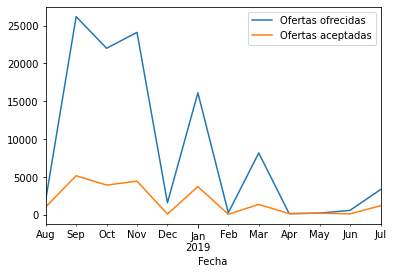

In [700]:
revision_datos(train_M1_informativo)

In [701]:


train_M1_1=train_M1[['Cliente',  'Marca',
       'Cupo', 'Nr', 'Hl', 'Dcto', 'Flag_ejecutada', 'dias',"var1","var6"]]
test_M1_1 = test_M1[['Cliente',  'Marca',
       'Cupo', 'Nr', 'Hl', 'Dcto', 'Flag_ejecutada', 'dias',"var1","var6"]]
Train_M1=test_M1_1[["Cliente","Marca","Cupo","Flag_ejecutada"]].merge(train_M1_1.groupby(["Cliente","Cupo","Marca"]).sum().add_prefix("SUM_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)
Train_M1=Train_M1.merge(train_M1_1.groupby(["Cliente","Cupo","Marca"]).mean().add_prefix("MEAN_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)
Train_M1=Train_M1.merge(train_M1_1.groupby(["Cliente","Cupo","Marca"]).min().add_prefix("Min_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)

In [702]:
# AGREGADO - nueva columna Flag_ofrecida contiene las ofertas que
# se le hicieron al cliente en el periodo seleccionado
# train_M1_1_ofertas_ofrecidas = train_M1_1.groupby(['Cliente'])[['Flag_ejecutada']].count().reset_index()
# train_M1_1_ofertas_ofrecidas.rename(columns={'Flag_ejecutada':'Flag_ofrecida'},inplace=True)
# Train_M1 = Train_M1.merge(train_M1_1_ofertas_ofrecidas,on='Cliente',how='left')

In [703]:
Train_M1=Train_M1.merge(clientes_atributos[["Cliente","TipoPoblacion","Estrato","EF"]],on="Cliente",how="left")

In [704]:
# Train_M1=Train_M1.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4']],on="Cliente",how="left")
Train_M1=Train_M1.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4','Cluster_C5']],on="Cliente",how="left")
# Train_M1=Train_M1.merge(clusters[['Cliente','Cluster_C4']],on="Cliente",how="left")

In [705]:
test = pd.read_csv(url+"/test.csv")
testM1 = test[(test["Marca"]==40)&(test["Cupo"]==16)]
testM2 = test[(test["Marca"]==39)&(test["Cupo"]==20)]
testM3 = test[(test["Marca"]==29)&(test["Cupo"]==9)]

test_M1=pd.concat([M120194_v1,M120195_v1,M120196_v1,M120197_v1,M120198_v1]) # subió
# test_M1=pd.concat([M120193_v1,
#                    M120194_v1,M120195_v1,M120196_v1,M120197_v1,M120198_v1])

In [706]:
test_M1_1=test_M1[['Cliente', 'Marca',
       'Cupo', 'Nr', 'Hl', 'Dcto', 'Flag_ejecutada', 'dias',"var1","var6"]]

Test_M1=testM1[["Cliente","Marca","Cupo"]].merge(test_M1_1.groupby(["Cliente","Cupo","Marca"]).sum().add_prefix("SUM_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)
Test_M1=Test_M1.merge(test_M1_1.groupby(["Cliente","Cupo","Marca"]).mean().add_prefix("MEAN_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)
Test_M1=Test_M1.merge(test_M1_1.groupby(["Cliente","Cupo","Marca"]).min().add_prefix("Min_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)


In [707]:
#grupo1 = test_M1_1.groupby(["Cliente","Cupo","Marca"]).agg({"Dcto":"count"}).add_prefix("Ventas_c_")
#grupo1_1 = test_M1_1[test_M1_1["Dcto"]!=0].groupby(["Cliente","Cupo","Marca"]).agg({"Dcto":"count"}).add_prefix("DD_c_")
#Test_M1=Test_M1.merge(grupo1,on=["Cliente","Marca","Cupo"],how="left")
#Test_M1=Test_M1.merge(grupo1_1,on=["Cliente","Marca","Cupo"],how="left")


In [708]:
# AGREGADO - nueva columna Flag_ofrecida contiene las ofertas que
# se le hicieron al cliente en el periodo seleccionado
# test_M1_1_ofertas_ofrecidas = test_M1_1.groupby(['Cliente'])[['Flag_ejecutada']].count().reset_index()
# test_M1_1_ofertas_ofrecidas.rename(columns={'Flag_ejecutada':'Flag_ofrecida'},inplace=True)
# Test_M1 = Test_M1.merge(test_M1_1_ofertas_ofrecidas,on='Cliente',how='left')

In [709]:

Test_M1=Test_M1.merge(clientes_atributos[["Cliente","TipoPoblacion","Estrato","EF"]],on="Cliente",how="left")

In [710]:
# Test_M1=Test_M1.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4']],on="Cliente",how="left")
Test_M1=Test_M1.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4','Cluster_C5']],on="Cliente",how="left")
# Test_M1=Test_M1.merge(clusters[['Cliente','Cluster_C4']],on="Cliente",how="left")

In [711]:
# MODELADO
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
param = {
    'bagging_freq': 5, #5
    'bagging_fraction': 0.4, #0.4
    'boost_from_average':'false',
    'min_child_samples': 30,
    'boost': 'gbdt',
    'feature_fraction': 0.5, #0.05
    'learning_rate': 0.01, #0.01
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80, #80
    'min_sum_hessian_in_leaf': 10, #10
    'num_leaves': 13, #13
    'num_threads': 8, 
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    "is_unbalance":False,
    "random_state":1234
}
train_df=Train_M1
test_df=Test_M1
features = [c for c in train_df.columns if c not in ["Cliente","Cupo","Marca","Flag_ejecutada"]]#"SUM_flagdigital","SUM_flagpedidoanulado","flagsupervisor"]]
target=train_df["Flag_ejecutada"]
train_df.fillna(train_df.mean(), inplace=True) #reemplazar nan con media
test_df.fillna(test_df.mean(), inplace=True) 

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))   

Fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.822139	valid_1's auc: 0.731693
Early stopping, best iteration is:
[414]	training's auc: 0.782541	valid_1's auc: 0.741848
Fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.82304	valid_1's auc: 0.726123
Early stopping, best iteration is:
[218]	training's auc: 0.767228	valid_1's auc: 0.731172
Fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.825653	valid_1's auc: 0.719901
Early stopping, best iteration is:
[585]	training's auc: 0.800258	valid_1's auc: 0.721776
Fold 3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.829192	valid_1's auc: 0.708308
Early stopping, best iteration is:
[634]	training's auc: 0.806624	valid_1's auc: 0.712639
Fold 4
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.822907	valid_1's auc: 0.732973
Early 

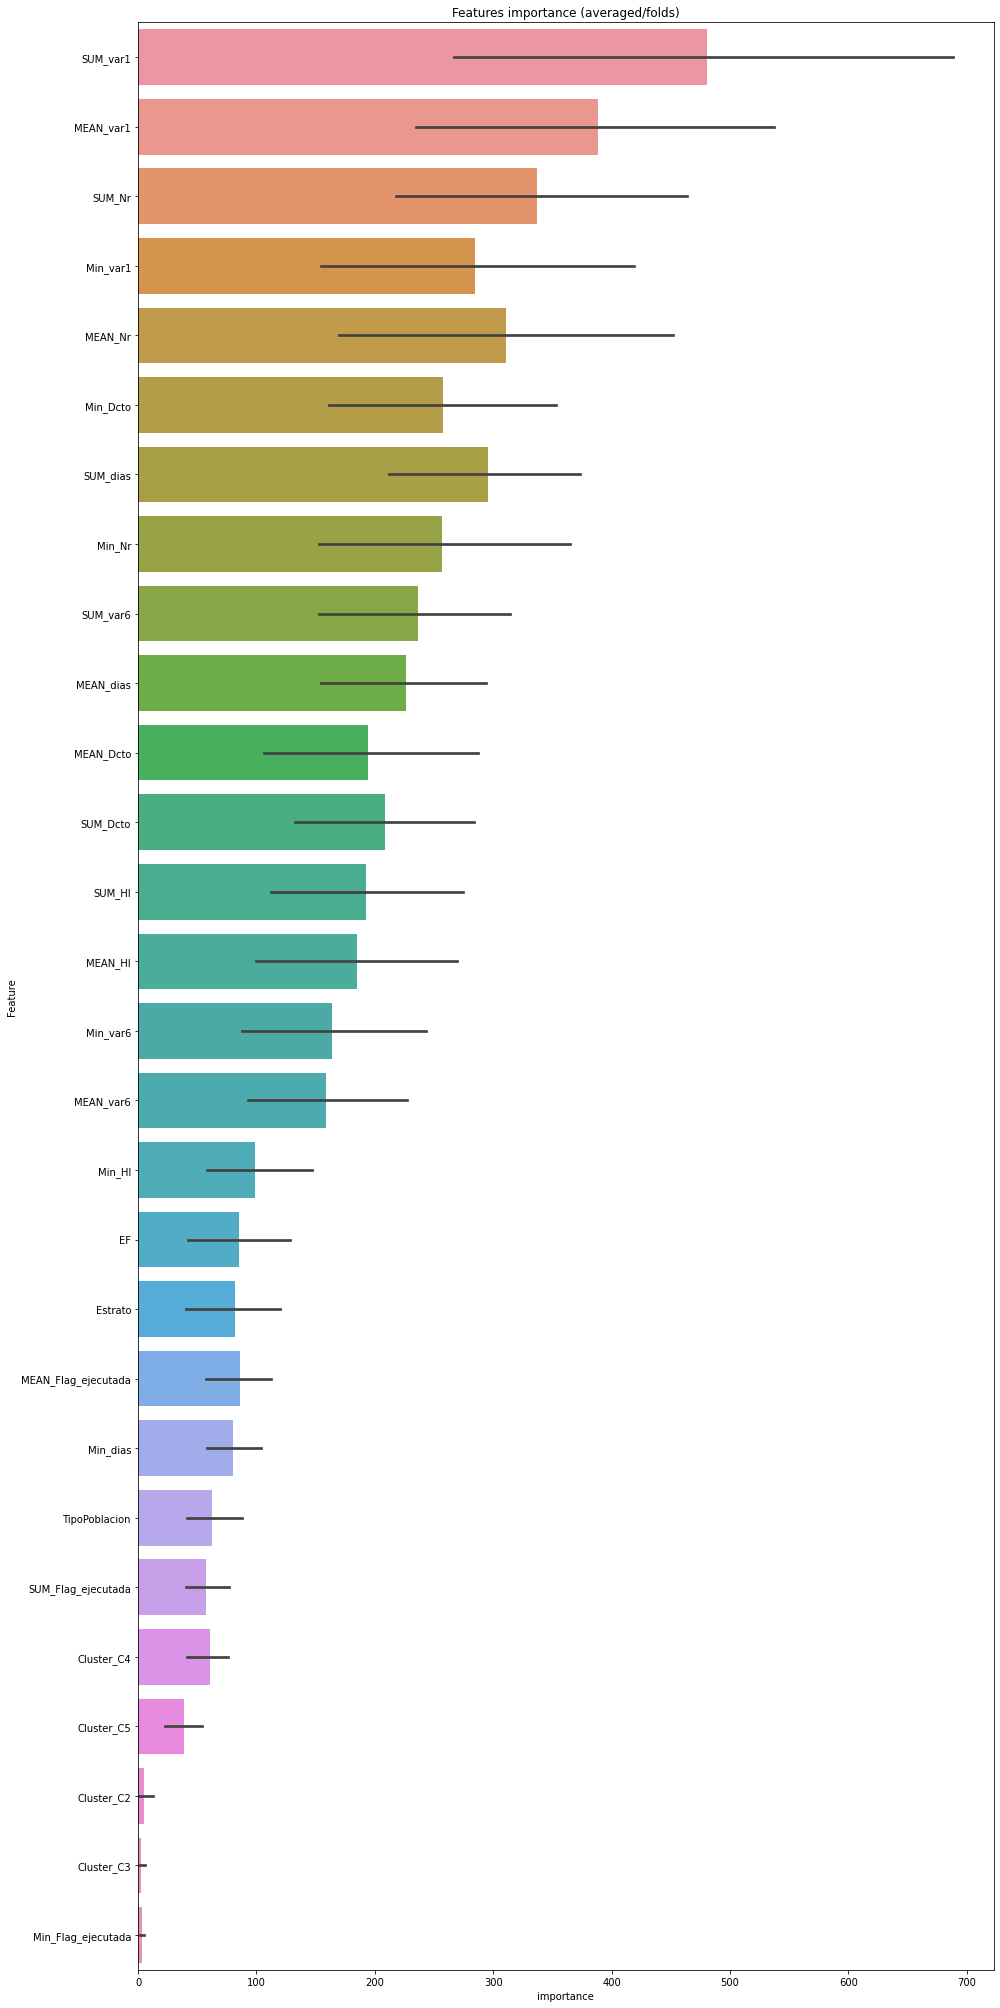

In [712]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()


In [713]:
Test_M1["pred"] = predictions
t1=test[(test["Marca"]==40)&(test["Cupo"]==16)]
t1=t1.merge(Test_M1[["Cliente","Marca","Cupo","pred"]],on=["Cliente","Marca","Cupo"],how="left")
t1["Ejecuto_Promo"] = t1["pred"].fillna(0)

In [714]:
# Grupo 2
M2["var1"]=M2["Hl"]/M2["Nr"]
M2["var2"]=M2["Hl"]*M2["Nr"]
M2["var3"]=M2["Nr"]*M2["Nr"]
M2["var4"]=M2["Hl"]*M2["Hl"]
M2["var5"]=M2["Nr"]/M2["Hl"]
M2["var6"]=M2["Nr"]+M2["Hl"]

M220181 = M2[M2["campañas"]=="20181"]
M220182 = M2[M2["campañas"]=="20182"]
M220183 = M2[M2["campañas"]=="20183"]
M220184 = M2[M2["campañas"]=="20184"]
M220185 = M2[M2["campañas"]=="20185"]
M220186 = M2[M2["campañas"]=="20186"]
M220187 = M2[M2["campañas"]=="20187"]
M220188 = M2[M2["campañas"]=="20188"]
M220189 = M2[M2["campañas"]=="20189"]
M2201810 = M2[M2["campañas"]=="201810"]
M2201811 = M2[M2["campañas"]=="201811"]
M2201812 = M2[M2["campañas"]=="201812"]
M220191 = M2[M2["campañas"]=="20191"]
M220192 = M2[M2["campañas"]=="20192"]
M220193 = M2[M2["campañas"]=="20193"]
M220194 = M2[M2["campañas"]=="20194"]
M220195 = M2[M2["campañas"]=="20195"]
M220196 = M2[M2["campañas"]=="20196"]
M220197 = M2[M2["campañas"]=="20197"]
M220198 = M2[M2["campañas"]=="20198"]

M220188_v1 = M220188.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M220189_v1 = M220189.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M2201810_v1 = M2201810.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M2201811_v1 = M2201811.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M2201812_v1 = M2201812.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M220191_v1 = M220191.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M220192_v1 = M220192.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M220193_v1 = M220193.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
#M220194_v1 = M220194.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
#M220195_v1 = M220195.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M220196_v1 = M220196.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M220197_v1 = M220197.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M220198_v1 = M220198.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [715]:
M220188_v1

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,campañas,var1,var2,var3,var4,var5,var6,Flag_ejecutada,Resta_Mes,Fecha_Hasta,Fecha_Desde,dias
0,2395,2018,8,1,0.0,39,20.0,45965.80,0.24,-30252.52,20188,0.000005,11031.7920,2.112855e+09,0.0576,191524.166667,45966.04,1,0,2018-08-30,2018-08-12,18
1,2447,2018,8,1,0.0,39,20.0,332343.48,1.07,-14138.97,20188,0.000003,355607.5236,1.104522e+11,1.1449,310601.383178,332344.55,1,0,2018-08-23,2018-08-15,8
2,2541,2018,8,1,0.0,39,20.0,54959.72,0.30,-40333.82,20188,0.000005,16487.9160,3.020571e+09,0.0900,183199.066667,54960.02,1,0,2018-08-22,2018-08-12,10
3,2580,2018,8,1,0.0,39,20.0,382565.27,1.37,-54712.29,20188,0.000004,524114.4199,1.463562e+11,1.8769,279244.722628,382566.64,1,0,2018-08-16,2018-08-12,4
4,2640,2018,8,1,0.0,39,20.0,72464.22,0.27,-13109.81,20188,0.000004,19565.3394,5.251063e+09,0.0729,268386.000000,72464.49,1,0,2018-08-17,2018-08-13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,9570,2018,8,1,0.0,39,20.0,109532.95,0.39,-14033.78,20188,0.000004,42717.8505,1.199747e+10,0.1521,280853.717949,109533.34,1,0,2018-08-19,2018-08-13,6
118,9623,2018,8,1,0.0,39,20.0,27085.86,0.12,-11493.56,20188,0.000004,3250.3032,7.336438e+08,0.0144,225715.500000,27085.98,1,0,2018-08-20,2018-08-15,5
119,9700,2018,8,1,0.0,39,20.0,26131.87,0.12,-11951.26,20188,0.000005,3135.8244,6.828746e+08,0.0144,217765.583333,26131.99,1,0,2018-08-19,2018-08-13,6
120,9947,2018,8,1,0.0,39,20.0,229585.88,0.80,-27035.39,20188,0.000003,183668.7040,5.270968e+10,0.6400,286982.350000,229586.68,1,0,2018-08-16,2018-08-13,3


In [716]:
train_M2=pd.concat([M220196_v1,M220197_v1])
# train_M2=pd.concat([M220196_v1,M220197_v1,M220198_v1])
# train_M2=pd.concat([M220188_v1,M220189_v1,M2201812_v1,M220192_v1,
#                     M220196_v1,M220197_v1])
test_M2=M220198_v1


train_M2_1=train_M2[['Cliente', 'Marca',
       'Cupo', 'Nr', 'Hl', 'Dcto', 'Flag_ejecutada',"var1","var2","var3","var4","var5","var6"]]
test_M2_1 = test_M2[['Cliente', 'Marca',"var1","var2","var3","var4","var5","var6",
       'Cupo', 'Nr', 'Hl', 'Dcto', 'Flag_ejecutada']]
Train_M2=test_M2_1[["Cliente","Marca","Cupo","Flag_ejecutada"]].merge(train_M2_1.groupby(["Cliente","Cupo","Marca"]).sum().add_prefix("SUM_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)
Train_M2=Train_M2.merge(train_M2_1.groupby(["Cliente","Cupo","Marca"]).mean().add_prefix("MEAN_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)



In [717]:
# AGREGADO - nueva columna Flag_ofrecida contiene las ofertas que
# se le hicieron al cliente en el periodo seleccionado
# train_M2_1_ofertas_ofrecidas = train_M2_1.groupby(['Cliente'])[['Flag_ejecutada']].count().reset_index()
# train_M2_1_ofertas_ofrecidas.rename(columns={'Flag_ejecutada':'Flag_ofrecida'},inplace=True)
# Train_M2 = Train_M2.merge(train_M2_1_ofertas_ofrecidas,on='Cliente',how='left')

In [718]:
Train_M2=Train_M2.merge(clientes_atributos[["Cliente","Estrato","EF"]],on="Cliente",how="left")

In [719]:
# Train_M2=Train_M2.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4']],on="Cliente",how="left")
Train_M2=Train_M2.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4','Cluster_C5']],on="Cliente",how="left")
# Train_M2=Train_M2.merge(clusters[['Cliente','Cluster_C4']],on="Cliente",how="left")

In [720]:
train_M2['Flag_ejecutada'].value_counts()

0    601
1    258
Name: Flag_ejecutada, dtype: int64

In [721]:
test = pd.read_csv(url+"/test.csv")
testM1 = test[(test["Marca"]==40)&(test["Cupo"]==16)]
testM2 = test[(test["Marca"]==39)&(test["Cupo"]==20)]
testM3 = test[(test["Marca"]==29)&(test["Cupo"]==9)]

# test_M2=pd.concat([M220197_v1,M220198_v1])
test_M2=pd.concat([M220197_v1,M220198_v1])
# test_M2=pd.concat([M220189_v1,M2201812_v1,M220192_v1,
#                    M220197_v1,M220198_v1])

In [722]:

testM2 = test[(test["Marca"]==39)&(test["Cupo"]==20)]
test_M2_1=test_M2[['Cliente', 'ClaseEnvase', 'Marca',
       'Cupo', 'Nr', 'Hl', 'Dcto', 'Flag_ejecutada',"var1","var2","var3","var4","var5","var6"]]

Test_M2=testM2[["Cliente","Marca","Cupo"]].merge(test_M2_1.groupby(["Cliente","Cupo","Marca"]).sum().add_prefix("SUM_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)
Test_M2=Test_M2.merge(test_M2_1.groupby(["Cliente","Cupo","Marca"]).mean().add_prefix("MEAN_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)


In [723]:
# AGREGADO - nueva columna Flag_ofrecida contiene las ofertas que
# se le hicieron al cliente en el periodo seleccionado
# test_M2_1_ofertas_ofrecidas = test_M2_1.groupby(['Cliente'])[['Flag_ejecutada']].count().reset_index()
# test_M2_1_ofertas_ofrecidas.rename(columns={'Flag_ejecutada':'Flag_ofrecida'},inplace=True)
# Test_M2 = Test_M2.merge(test_M2_1_ofertas_ofrecidas,on='Cliente',how='left')

In [724]:
Test_M2=Test_M2.merge(clientes_atributos[["Cliente","Estrato","EF"]],on="Cliente",how="left")

In [725]:
# Test_M2=Test_M2.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4']],on="Cliente",how="left")
Test_M2=Test_M2.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4','Cluster_C5']],on="Cliente",how="left")

In [726]:
# MODELADO
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
param = {
    'bagging_freq': 5, #5
    'bagging_fraction': 0.4, #0.4
    'boost_from_average':'false',
    'min_child_samples': 30,
    'boost': 'gbdt',
    'feature_fraction': 0.5, #0.05
    'learning_rate': 0.01, #0.01
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80, #80
    'min_sum_hessian_in_leaf': 10, #10
    'num_leaves': 13, #13
    'num_threads': 8, 
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    "is_unbalance":False,
    "random_state":1234
}
train_df=Train_M2
test_df=Test_M2
features = [c for c in train_df.columns if c not in ["Cliente","Cupo","Marca","Flag_ejecutada"]]#"SUM_flagdigital","SUM_flagpedidoanulado","flagsupervisor"]]
target=train_df["Flag_ejecutada"]
train_df.fillna(train_df.mean(), inplace=True) #reemplazar nan con media
test_df.fillna(test_df.mean(), inplace=True) 

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))   


Fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.74334	valid_1's auc: 0.662082
Early stopping, best iteration is:
[255]	training's auc: 0.718788	valid_1's auc: 0.698759
Fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.736906	valid_1's auc: 0.651834
Early stopping, best iteration is:
[329]	training's auc: 0.71775	valid_1's auc: 0.669993
Fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.730254	valid_1's auc: 0.717073
Early stopping, best iteration is:
[871]	training's auc: 0.727229	valid_1's auc: 0.722403
Fold 3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.741693	valid_1's auc: 0.627462
Early stopping, best iteration is:
[610]	training's auc: 0.733498	valid_1's auc: 0.632882
Fold 4
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.736978	valid_1's auc: 0.666847
Early s

In [727]:

Test_M2["pred"] = predictions
t2=test[(test["Marca"]==39)&(test["Cupo"]==20)]
t2=t2.merge(Test_M2[["Cliente","Marca","Cupo","pred"]],on=["Cliente","Marca","Cupo"],how="left")
t2["Ejecuto_Promo"] = t2["pred"].fillna(0)

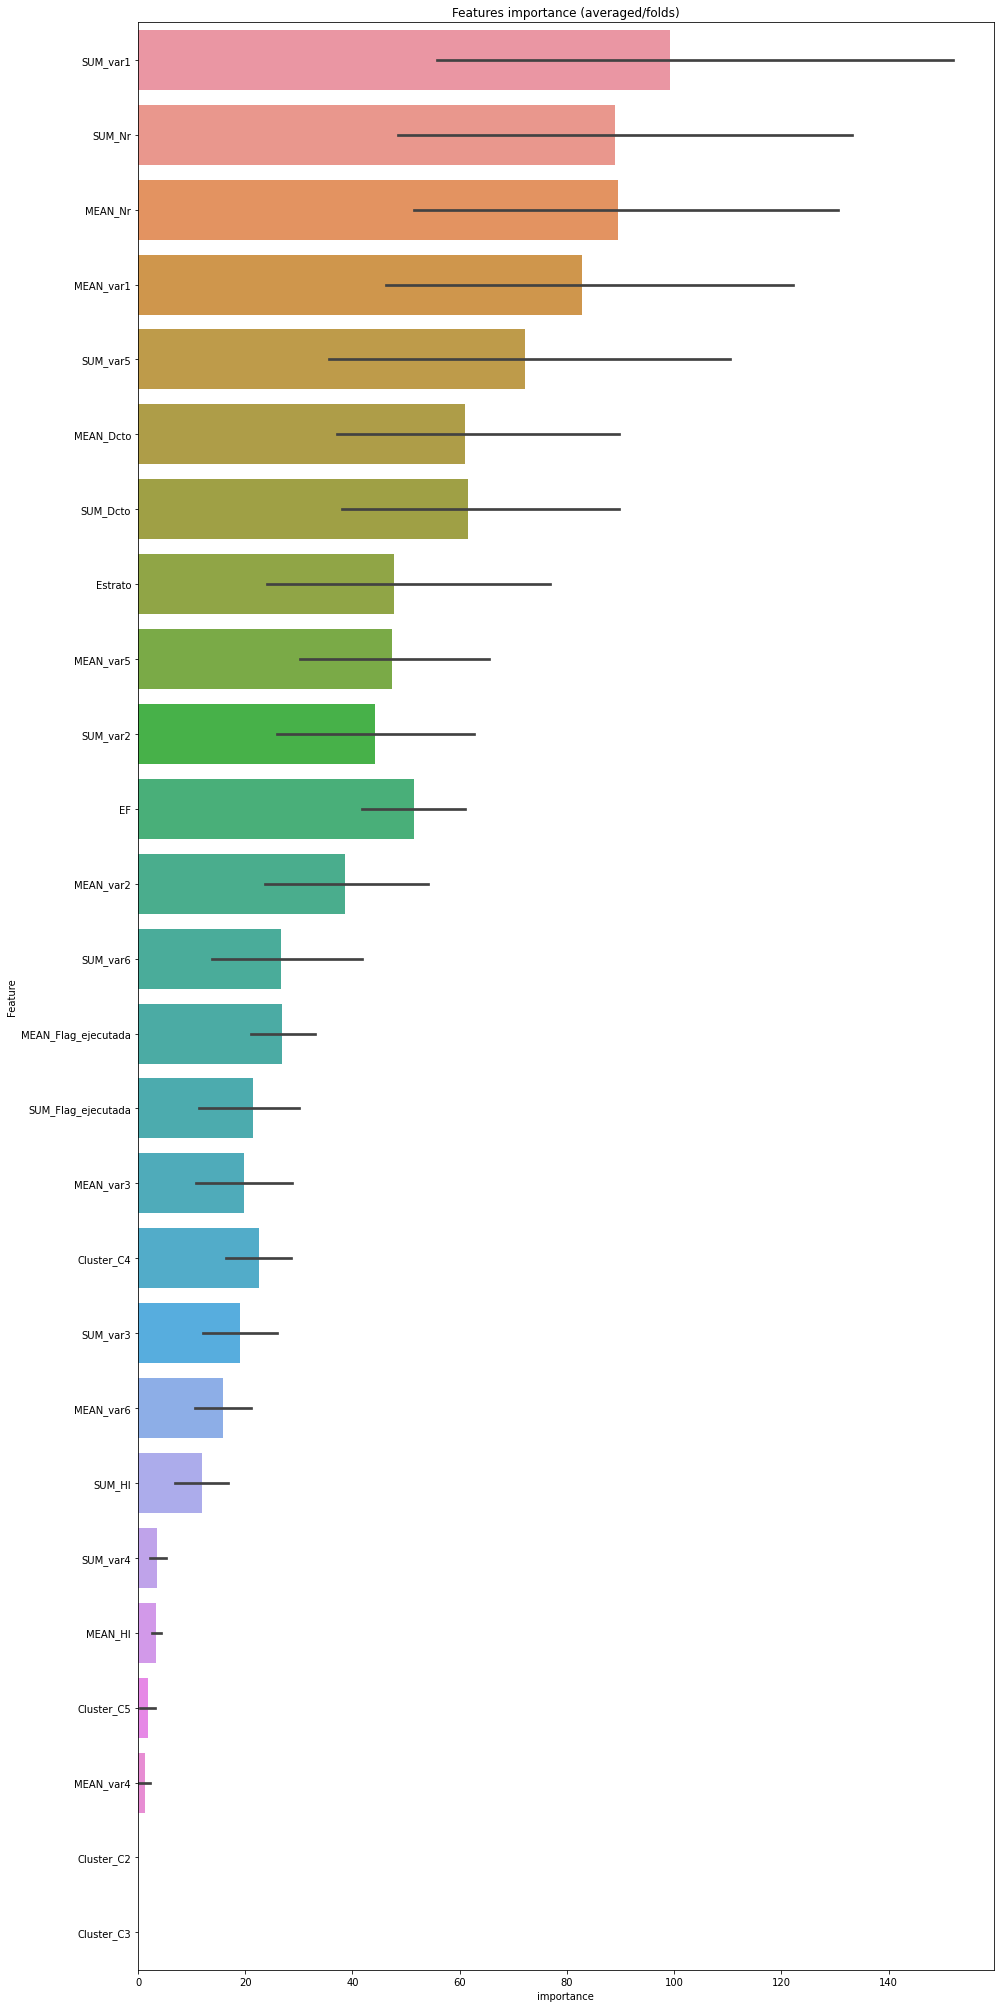

In [728]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()


In [729]:
# Grupo 3
M3["var1"]=M3["Hl"]/M3["Nr"]
M3["var2"]=M3["Hl"]*M3["Nr"]
M3["var3"]=M3["Nr"]*M3["Nr"]
M3["var4"]=M3["Hl"]*M3["Hl"]
M3["var5"]=M3["Nr"]/M3["Hl"]
M3["var6"]=M3["Nr"]+M3["Hl"]
M320181 = M3[M3["campañas"]=="20181"]
M320182 = M3[M3["campañas"]=="20182"]
M320183 = M3[M3["campañas"]=="20183"]
M320184 = M3[M3["campañas"]=="20184"]
M320185 = M3[M3["campañas"]=="20185"]
M320186 = M3[M3["campañas"]=="20186"]
M320187 = M3[M3["campañas"]=="20187"]
M320188 = M3[M3["campañas"]=="20188"]
M320189 = M3[M3["campañas"]=="20189"]
M3201810 = M3[M3["campañas"]=="201810"]
M3201811 = M3[M3["campañas"]=="201811"]
M3201812 = M3[M3["campañas"]=="201812"]
M320191 = M3[M3["campañas"]=="20191"]
M320192 = M3[M3["campañas"]=="20192"]
M320193 = M3[M3["campañas"]=="20193"]
M320194 = M3[M3["campañas"]=="20194"]
M320195 = M3[M3["campañas"]=="20195"]
M320196 = M3[M3["campañas"]=="20196"]
M320197 = M3[M3["campañas"]=="20197"]
M320198 = M3[M3["campañas"]=="20198"]

M320188_v1 = M320188.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M320189_v1 = M320189.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M3201810_v1 = M3201810.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M3201811_v1 = M3201811.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M3201812_v1 = M3201812.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
#M320191_v1 = M320191.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M320192_v1 = M320192.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M320193_v1 = M320193.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M320194_v1 = M320194.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M320195_v1 = M320195.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M320196_v1 = M320196.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M320197_v1 = M320197.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()
M320198_v1 = M320198.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="inner").drop_duplicates()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [730]:
M320191.merge(promoDF1,right_on=["Cupo","Marca","Cliente","campañas"],left_on=["Cupo","Marca","Cliente","campañas"],how="left").drop_duplicates()

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,campañas,var1,var2,var3,var4,var5,var6,Flag_ejecutada,Resta_Mes,Fecha_Hasta,Fecha_Desde,dias
0,14,2019,1,0,3.0,29,9.0,11057.08,0.02,0.0,20191,0.000002,221.1416,1.222590e+08,0.0004,5.528540e+05,11057.10,NaN,NaN,NaN,NaN,NaN
1,19,2019,1,0,3.0,29,9.0,33171.25,0.05,0.0,20191,0.000002,1658.5625,1.100332e+09,0.0025,6.634250e+05,33171.30,NaN,NaN,NaN,NaN,NaN
2,38,2019,1,0,3.0,29,9.0,110570.84,0.15,0.0,20191,0.000001,16585.6260,1.222591e+10,0.0225,7.371389e+05,110570.99,NaN,NaN,NaN,NaN,NaN
3,45,2019,1,0,3.0,29,9.0,223642.01,0.30,0.0,20191,0.000001,67092.6030,5.001575e+10,0.0900,7.454734e+05,223642.31,NaN,NaN,NaN,NaN,NaN
4,66,2019,1,0,3.0,29,9.0,55910.50,0.08,0.0,20191,0.000001,4472.8400,3.125984e+09,0.0064,6.988812e+05,55910.58,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,14261,2019,1,0,3.0,29,9.0,55285.42,0.08,0.0,20191,0.000001,4422.8336,3.056478e+09,0.0064,6.910678e+05,55285.50,NaN,NaN,NaN,NaN,NaN
1857,14592,2019,1,0,3.0,29,9.0,2764.27,0.00,0.0,20191,0.000000,0.0000,7.641189e+06,0.0000,inf,2764.27,NaN,NaN,NaN,NaN,NaN
1858,14735,2019,1,0,3.0,29,9.0,11057.08,0.02,0.0,20191,0.000002,221.1416,1.222590e+08,0.0004,5.528540e+05,11057.10,NaN,NaN,NaN,NaN,NaN
1859,14816,2019,1,0,3.0,29,9.0,11057.08,0.02,0.0,20191,0.000002,221.1416,1.222590e+08,0.0004,5.528540e+05,11057.10,NaN,NaN,NaN,NaN,NaN


In [731]:
M3[M3['campañas']=='20191']

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,campañas,var1,var2,var3,var4,var5,var6
3529,14,2019,1,0,3.0,29,9.0,11057.08,0.02,0.0,20191,0.000002,221.1416,1.222590e+08,0.0004,5.528540e+05,11057.10
3753,19,2019,1,0,3.0,29,9.0,33171.25,0.05,0.0,20191,0.000002,1658.5625,1.100332e+09,0.0025,6.634250e+05,33171.30
4375,38,2019,1,0,3.0,29,9.0,110570.84,0.15,0.0,20191,0.000001,16585.6260,1.222591e+10,0.0225,7.371389e+05,110570.99
4623,45,2019,1,0,3.0,29,9.0,223642.01,0.30,0.0,20191,0.000001,67092.6030,5.001575e+10,0.0900,7.454734e+05,223642.31
5210,66,2019,1,0,3.0,29,9.0,55910.50,0.08,0.0,20191,0.000001,4472.8400,3.125984e+09,0.0064,6.988812e+05,55910.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886921,14261,2019,1,0,3.0,29,9.0,55285.42,0.08,0.0,20191,0.000001,4422.8336,3.056478e+09,0.0064,6.910678e+05,55285.50
1890221,14592,2019,1,0,3.0,29,9.0,2764.27,0.00,0.0,20191,0.000000,0.0000,7.641189e+06,0.0000,inf,2764.27
1891482,14735,2019,1,0,3.0,29,9.0,11057.08,0.02,0.0,20191,0.000002,221.1416,1.222590e+08,0.0004,5.528540e+05,11057.10
1892202,14816,2019,1,0,3.0,29,9.0,11057.08,0.02,0.0,20191,0.000002,221.1416,1.222590e+08,0.0004,5.528540e+05,11057.10


In [732]:
M3201810_v1

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,campañas,var1,var2,var3,var4,var5,var6,Flag_ejecutada,Resta_Mes,Fecha_Hasta,Fecha_Desde,dias


In [733]:
# train_M3=pd.concat([M320192_v1,M320193_v1,M320194_v1,M320195_v1,M320196_v1,M320197_v1])
train_M3=pd.concat([M3201811_v1,M3201812_v1, M320192_v1,M320193_v1,M320194_v1,M320195_v1,M320196_v1,M320197_v1])# fijo ->0.8105
# train_M3=pd.concat([M3201811_v1,M3201812_v1, M320192_v1,M320193_v1,M320194_v1,M320195_v1,M320196_v1,M320197_v1])
test_M3=M320198_v1


train_M3_1=train_M3[['Cliente', 'Marca',
       'Cupo', 'Nr', 'Hl', 'dias',"var1","var2","var3","var5","var6"]]
# train_M3_1=train_M3[['Cliente', 'Marca','Flag_ejecutada',
#        'Cupo', 'Nr', 'Hl', 'dias',"var1","var2","var3","var5","var6"]]
test_M3_1 = test_M3[['Cliente', 'Marca',
       'Cupo', 'Nr', 'Hl', 'Flag_ejecutada', 'dias',"var1","var2","var3","var5","var6"]]
Train_M3=test_M3_1[["Cliente","Marca","Cupo","Flag_ejecutada"]].merge(train_M3_1.groupby(["Cliente","Cupo","Marca"]).sum().add_prefix("SUM_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)

Train_M3=Train_M3.merge(train_M3_1.groupby(["Cliente","Cupo","Marca"]).mean().add_prefix("MEAN_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)
Train_M3=Train_M3.merge(train_M3_1[["Cliente","Cupo","Marca","var1","var2","var5","dias"]].groupby(["Cliente","Cupo","Marca"]).min().add_prefix("Max_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)


In [734]:
train_M3['Flag_ejecutada'].value_counts()

0    1777
1     327
Name: Flag_ejecutada, dtype: int64

In [735]:
# AGREGADO - nueva columna Flag_ofrecida contiene las ofertas que
# # se le hicieron al cliente en el periodo seleccionado
# train_M3_1_ofertas_ofrecidas = train_M3_1.groupby(['Cliente'])[['Flag_ejecutada']].count().reset_index()
# train_M3_1_ofertas_ofrecidas.rename(columns={'Flag_ejecutada':'Flag_ofrecida'},inplace=True)
# Train_M3 = Train_M3.merge(train_M3_1_ofertas_ofrecidas,on='Cliente',how='left')

In [736]:
Train_M3=Train_M3.merge(clientes_atributos[["Cliente","Estrato","EF"]],on="Cliente",how="left")

In [737]:
# Train_M3=Train_M3.merge(clusters[['Cliente','Cluster_C4','Cluster_C5']],on="Cliente",how="left")
#Train_M3=Train_M3.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4']],on="Cliente",how="left")
#Train_M3=Train_M3.merge(clusters[['Cliente','Cluster_C5']],on="Cliente",how="left")

In [738]:

# test_M3=pd.concat([M320193_v1,M320194_v1,M320195_v1,M320196_v1,M320197_v1,M320198_v1])
test_M3=pd.concat([M3201812_v1, M320192_v1,M320193_v1,M320194_v1,M320195_v1,M320196_v1,M320197_v1,M320198_v1]) # bueno
# test_M3=pd.concat([M3201811_v1,
#                    M3201812_v1, M320192_v1,M320193_v1,M320194_v1,M320195_v1,M320196_v1,M320197_v1,M320198_v1])

test_M3_1=test_M3[['Cliente',  'Marca',
       'Cupo', 'Nr', 'Hl', 'Flag_ejecutada', 'dias',"var1","var2","var3","var5","var6"]]

Test_M3=testM3[["Cliente","Marca","Cupo"]].merge(test_M3_1.groupby(["Cliente","Cupo","Marca"]).sum().add_prefix("SUM_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)
Test_M3=Test_M3.merge(test_M3_1.groupby(["Cliente","Cupo","Marca"]).mean().add_prefix("MEAN_").reset_index(),
                                                            on=["Cliente","Marca","Cupo"],how="inner").fillna(0)
Test_M3=Test_M3.merge(test_M3_1[["Cliente","Cupo","Marca","var1","var2","var5","dias"]].groupby(["Cliente","Cupo","Marca"]).min().add_prefix("Max_").reset_index(),
                                                           on=["Cliente","Marca","Cupo"],how="inner").fillna(0)

In [739]:
# AGREGADO - nueva columna Flag_ofrecida contiene las ofertas que
# se le hicieron al cliente en el periodo seleccionado
# test_M3_1_ofertas_ofrecidas = test_M3_1.groupby(['Cliente'])[['Flag_ejecutada']].count().reset_index()
# test_M3_1_ofertas_ofrecidas.rename(columns={'Flag_ejecutada':'Flag_ofrecida'},inplace=True)
# Test_M3 = Test_M3.merge(test_M3_1_ofertas_ofrecidas,on='Cliente',how='left')

In [740]:
Test_M3=Test_M3.merge(clientes_atributos[["Cliente","Estrato","EF"]],on="Cliente",how="left")

In [741]:
# Test_M3=Test_M3.merge(clusters[['Cliente','Cluster_C4','Cluster_C5']],on="Cliente",how="left")
# Test_M3=Test_M3.merge(clusters[['Cliente','Cluster_C2','Cluster_C3','Cluster_C4']],on="Cliente",how="left")
# Test_M3=Test_M3.merge(clusters[['Cliente','Cluster_C5']],on="Cliente",how="left")

In [742]:
# MODELADO
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
param = {
    'bagging_freq': 5, #5
    'bagging_fraction': 0.4, #0.4
    'boost_from_average':'false',
    'min_child_samples': 30,
    'boost': 'gbdt',
    'feature_fraction': 0.5, #0.05
    'learning_rate': 0.01, #0.01
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80, #80
    'min_sum_hessian_in_leaf': 10, #10
    'num_leaves': 13, #13
    'num_threads': 8, 
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    "is_unbalance":False,
    "random_state":1234
}
train_df=Train_M3
test_df=Test_M3
features = [c for c in train_df.columns if c not in ["Cliente","Cupo","Marca","Flag_ejecutada"]]#"SUM_flagdigital","SUM_flagpedidoanulado","flagsupervisor"]]
target=train_df["Flag_ejecutada"]
train_df.fillna(train_df.mean(), inplace=True) #reemplazar nan con media
test_df.fillna(test_df.mean(), inplace=True) 

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))   

Fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.675232	valid_1's auc: 0.47043
Early stopping, best iteration is:
[85]	training's auc: 0.665194	valid_1's auc: 0.592742
Fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.678584	valid_1's auc: 0.397749
Early stopping, best iteration is:
[7]	training's auc: 0.593454	valid_1's auc: 0.653846
Fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.687647	valid_1's auc: 0.273374
Early stopping, best iteration is:
[1]	training's auc: 0.578238	valid_1's auc: 0.357724
Fold 3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.661837	valid_1's auc: 0.349932
Early stopping, best iteration is:
[1]	training's auc: 0.57919	valid_1's auc: 0.390244
Fold 4
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.694064	valid_1's auc: 0.488144
Early stopping

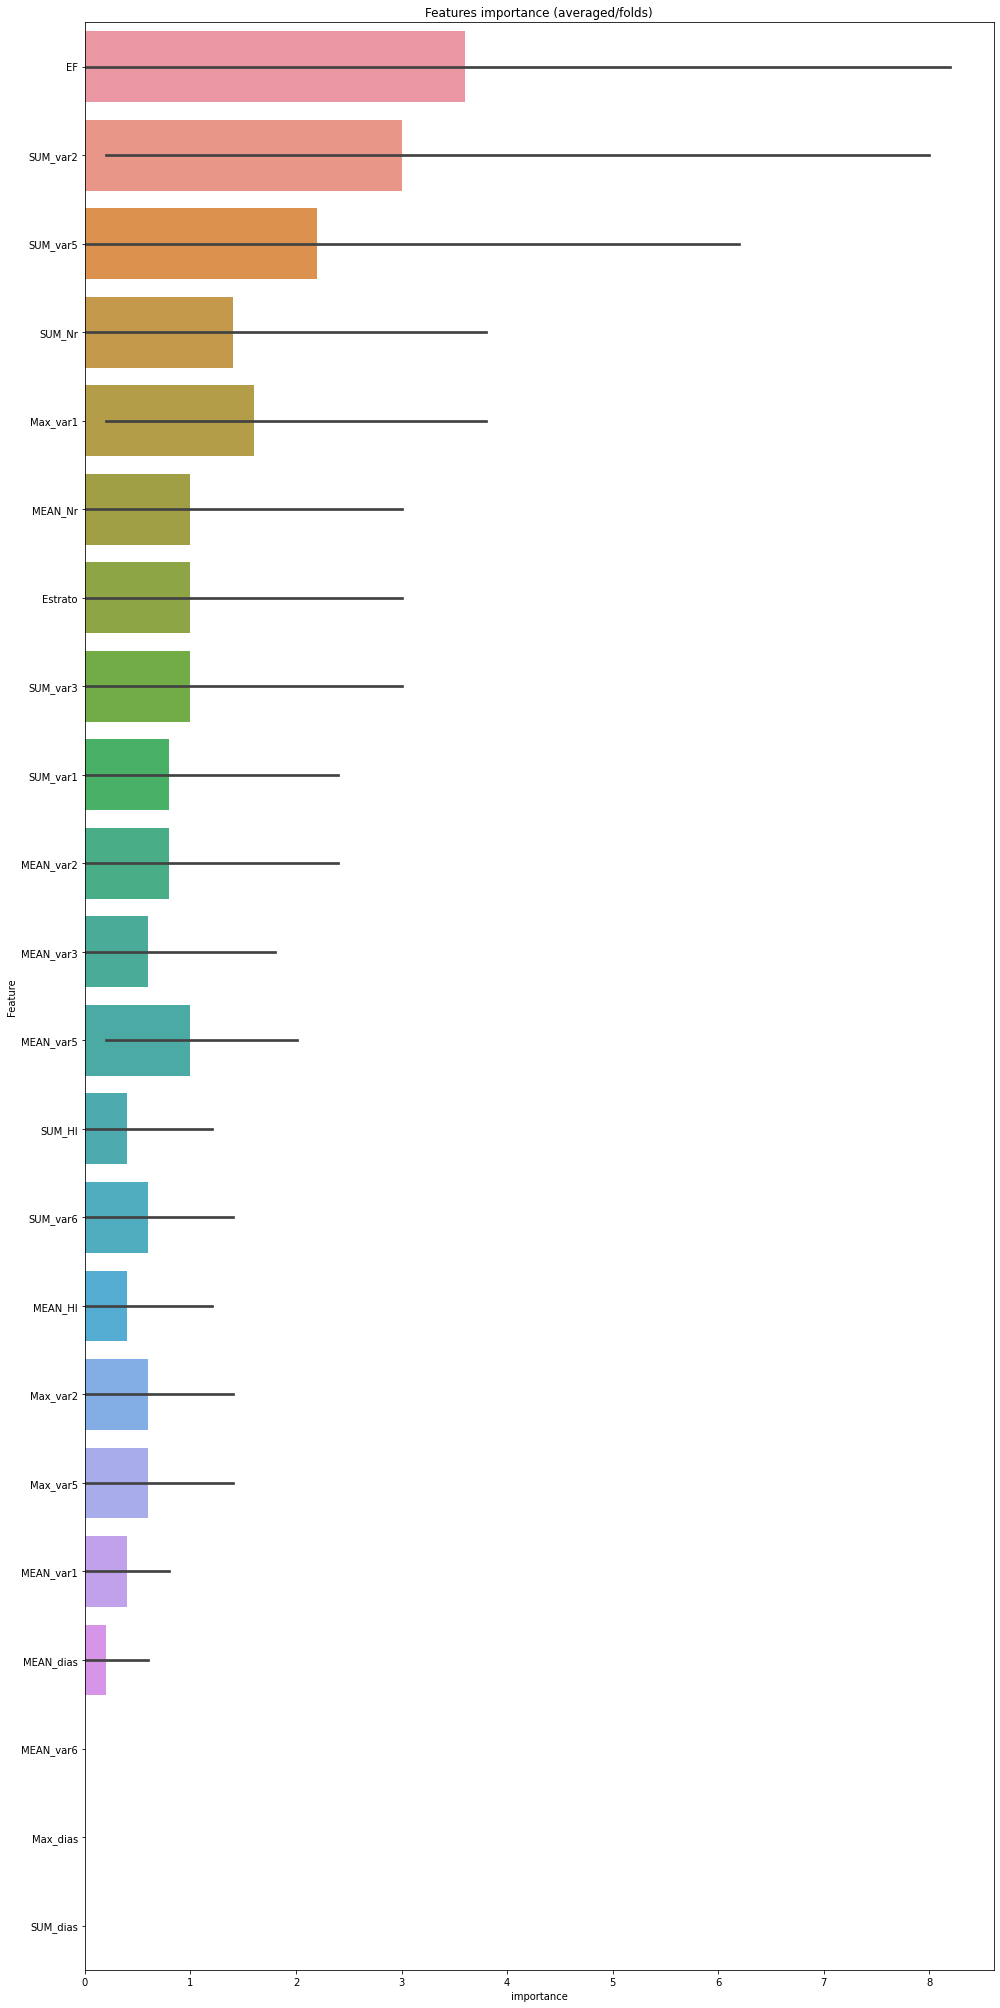

In [743]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()


In [744]:

Test_M3["pred"] = predictions
t3= test[(test["Marca"]==29)&(test["Cupo"]==9)]
t3=t3.merge(Test_M3[["Cliente","Marca","Cupo","pred"]],on=["Cliente","Marca","Cupo"],how="left")
t3["Ejecuto_Promo"] = t3["pred"].fillna(0)

In [745]:
consolidado= pd.concat([t1, t2, t3])
del consolidado["pred"]
final=test.merge(consolidado,on=["Cliente","Marca","Cupo"],how="left")
del final["Ejecuto_Promo_x"]
final=final.rename(columns={"Ejecuto_Promo_y":"Ejecuto_Promo"})#.to_csv("intento4.csv",index=False)
P1=promoDF1[promoDF1["campañas"]=="20199"][["Cupo","Marca","Cliente","Flag_ejecutada"]]
P1[P1["Flag_ejecutada"]==1]

,Cupo,Marca,Cliente,Flag_ejecutada
284831,16.0,40,1584,1
416358,16.0,40,367,1
416370,16.0,40,2113,1


In [746]:
f1=consolidado.merge(P1[P1["Flag_ejecutada"]==1],on=["Cliente","Marca","Cupo"],how="left").fillna(0)
f1["Ejecuto_Promo"]=f1["Flag_ejecutada"] + f1["Ejecuto_Promo"]
f1["Ejecuto_Promo"]=np.where(f1["Ejecuto_Promo"]>1,1,f1["Ejecuto_Promo"])
del f1["Flag_ejecutada"]
f1.to_csv("intentoFinal.csv",index=False)